# Emotional detection


## Import library

In [87]:
import os
import random
import sys
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow
py.init_notebook_mode(connected=True)
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm
input_duration=3

## Import Data

In [88]:
dir_list = os.listdir('C:\\Users\\ruizh\\Downloads\\sentiment-predictor-for-stress-detection-main\\Audio_Speech_Actors_01-24')
dir_list.sort()
print(dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


## Data preprocessing

In [89]:
# Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('C:\\Users\\ruizh\\Documents\\Y2S2\\tryhack\\emo_models\\Audio_Speech_Actors_01-24\\' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'C:\\Users\\ruizh\\Documents\\Y2S2\\tryhack\\emo_models\\Audio_Speech_Actors_01-24\\' + i + '\\' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [90]:
print (len(data_df))
data_df.head(25)

1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,0,0,0,1
1,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,0,0,1,1
2,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,0,1,0,1
3,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,0,1,1,1
4,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,0,0,0,2
5,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,0,0,1,2
6,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,0,1,0,2
7,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,0,1,1,2
8,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,1,0,0,2
9,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,1,0,1,2


In [6]:
filename = data_df.path[1021]
print (filename)
samples, sample_rate = librosa.load(filename)
sample_rate, samples

C:\Users\ruizh\Documents\Y2S2\tryhack\emo_models\Audio_Speech_Actors_01-24\Actor_18\03-01-01-01-01-02-18.wav


(22050,
 array([ 1.3188269e-13,  5.3687480e-13, -1.8068453e-13, ...,
        -1.9399832e-10,  7.1835565e-11,  0.0000000e+00], dtype=float32))

In [7]:
len(samples), sample_rate

(77989, 22050)

In [8]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [9]:
sample_rate/ len(samples)

0.28273218017925605

In [10]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

In [11]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [12]:
# Remove the slient voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([ 3.1145817e-08, -6.0422417e-07,  2.2115128e-06, ...,
         5.7531506e-05,  2.0480096e-05,  3.7168020e-06], dtype=float32),
 array([20992, 58880]))

In [13]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [14]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [15]:
# Silence trimmed Sound by manual trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

## Labeling

In [16]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

1440

In [17]:
#3 class: Positive, Neutral & Negative

# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

1440

In [18]:
# 5 class: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

1440

In [19]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1440

In [20]:
# Select the label set you want by commenting the unwanteds.

data_df['label'] = label5_list
# data_df['label'] = label3_list
# data_df['label'] = label5_list
#data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,0,0,0,1,male_none
1,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,0,0,1,1,male_none
2,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,0,1,0,1,male_none
3,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,0,1,1,1,male_none
4,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,0,0,0,2,male_calm


In [21]:
print (data_df.label.value_counts().keys())

Index(['male_none', 'female_none', 'male_calm', 'male_happy', 'male_sad',
       'male_angry', 'male_fearful', 'female_calm', 'female_happy',
       'female_sad', 'female_angry', 'female_fearful'],
      dtype='object', name='label')


In [22]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

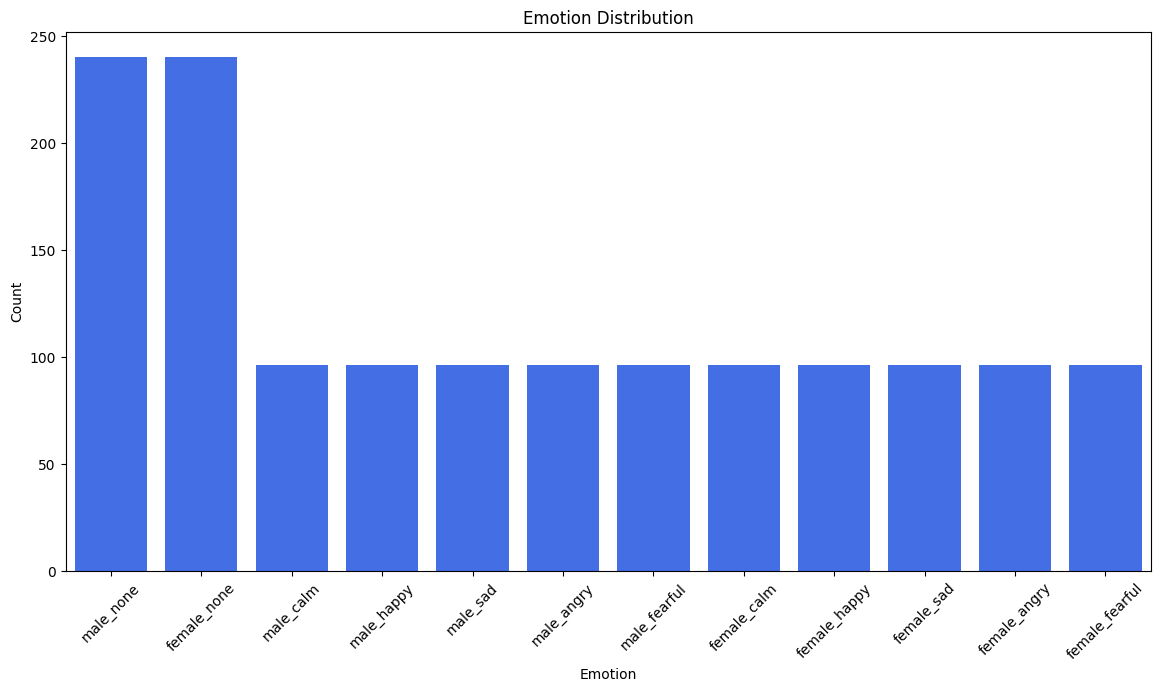

In [23]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

## Split data

In [24]:
# Male Data Set

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head(50)

400


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,0,0,0,2,male_calm
1,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,0,0,1,2,male_calm
2,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,0,1,0,2,male_calm
3,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,0,1,1,2,male_calm
4,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,1,0,0,2,male_calm
5,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,1,0,1,2,male_calm
6,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,1,1,0,2,male_calm
7,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,1,1,1,2,male_calm
8,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,0,0,0,3,male_happy
9,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,1,male,0,0,1,3,male_happy


In [25]:
print(len(data3_df))
data3_df.head(80)

80


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,21,male,0,0,0,2,male_calm
1,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,21,male,0,0,1,2,male_calm
2,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,21,male,0,1,0,2,male_calm
3,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,21,male,0,1,1,2,male_calm
4,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,21,male,1,0,0,2,male_calm
...,...,...,...,...,...,...,...,...,...
75,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,23,male,0,1,1,6,male_fearful
76,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,23,male,1,0,0,6,male_fearful
77,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,23,male,1,0,1,6,male_fearful
78,C:\Users\ruizh\Documents\Y2S2\tryhack\emo_mode...,1,23,male,1,1,0,6,male_fearful


## Analyse features

In [26]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 400/400 [00:11<00:00, 35.46it/s]


In [27]:
data.head()

,feature
0,"[-70.26808, -70.26808, -70.26808, -70.26808, -..."
1,"[-67.55767, -67.55767, -67.55767, -67.55767, -..."
2,"[-69.69336, -69.69336, -69.69336, -69.69336, -..."
3,"[-69.051476, -69.051476, -69.051476, -69.05147..."
4,"[-73.84186, -73.84186, -73.84186, -73.72008, -..."


In [28]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [29]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127472,-67.557671
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-65.447311,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,NaN,NaN,NaN
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858


In [30]:
newdf = pd.concat([df3,labels], axis=1)

In [31]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

400

In [32]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082,male_calm
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127472,-67.557671,male_calm
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359,male_calm
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,NaN,NaN,NaN,male_calm
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,male_calm
5,-69.243607,-69.243607,-69.243607,-69.243607,-68.902382,-67.983444,-68.089653,-67.897789,-65.258499,-67.171410,...,-57.186440,-61.189224,-67.108902,-67.508621,-66.246048,-68.733475,-69.243607,-69.243607,-69.243607,male_calm
6,-73.255318,-73.255318,-73.255318,-73.255318,-68.774933,-69.380905,-73.255318,-73.255318,-73.255318,-73.255318,...,-50.886692,-55.668213,-54.602642,-53.441685,-56.299820,-57.457932,-58.767605,-59.844353,-59.074680,male_calm
7,-70.746674,-70.746674,-70.025597,-69.131645,-70.746674,-70.746674,-70.746674,-70.746674,-70.746674,-70.746674,...,-70.746674,-70.746674,-70.079544,-69.590736,-69.203033,-70.159676,-70.445572,-68.199638,-67.593987,male_calm
8,-63.787254,-63.128746,-63.412743,-63.797016,-63.582291,-58.921696,-57.955513,-61.225422,-63.783241,-63.797016,...,-63.740913,-62.410637,-62.489479,-62.494827,-62.633003,-62.878506,NaN,NaN,NaN,male_happy
9,-60.981300,-60.116249,-60.978962,-60.952496,-60.982536,-60.983990,-60.981300,-60.981300,-60.981300,-60.249794,...,-60.981300,-60.981300,-60.981300,-60.981300,-60.981300,-60.981300,NaN,NaN,NaN,male_happy


In [33]:
rnewdf.isnull().sum().sum()

2284

In [34]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082,male_calm
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127472,-67.557671,male_calm
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359,male_calm
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,0.000000,0.000000,0.000000,male_calm
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,male_calm


## Data Processing

In [35]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

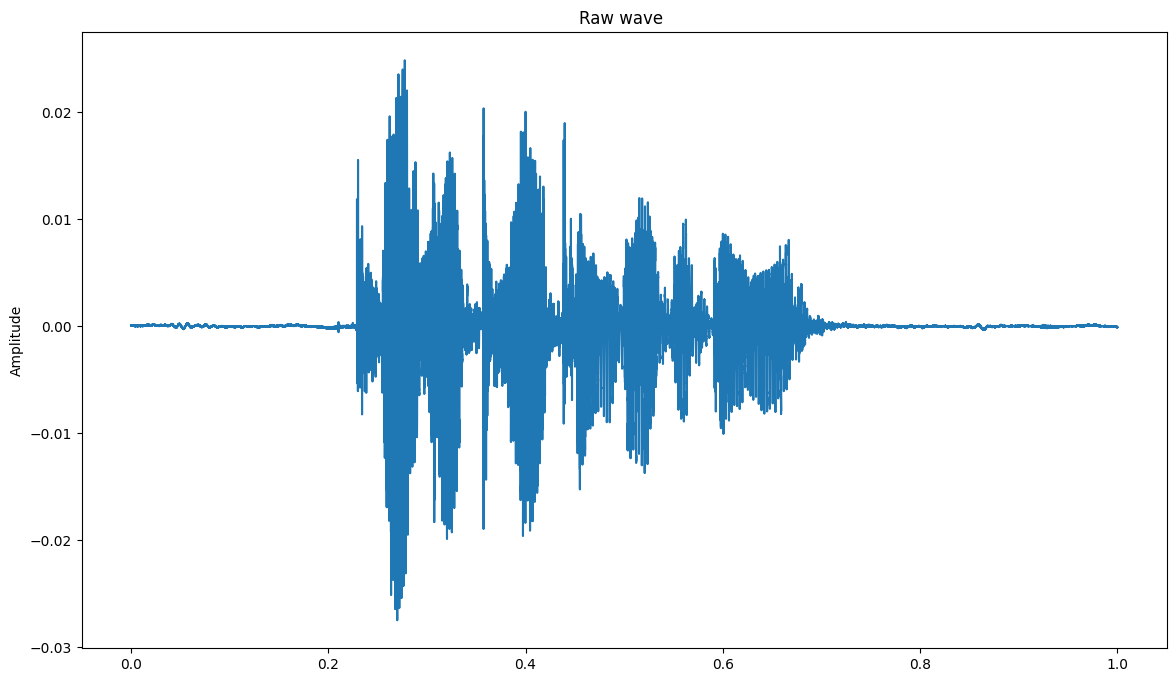

In [36]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.3)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

In [37]:
pitch??

Signature: pitch(data, sample_rate)
Source:   
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
File:      c:\users\ruizh\appdata\local\temp\ipykernel_55720\1506486044.py
Type:      function

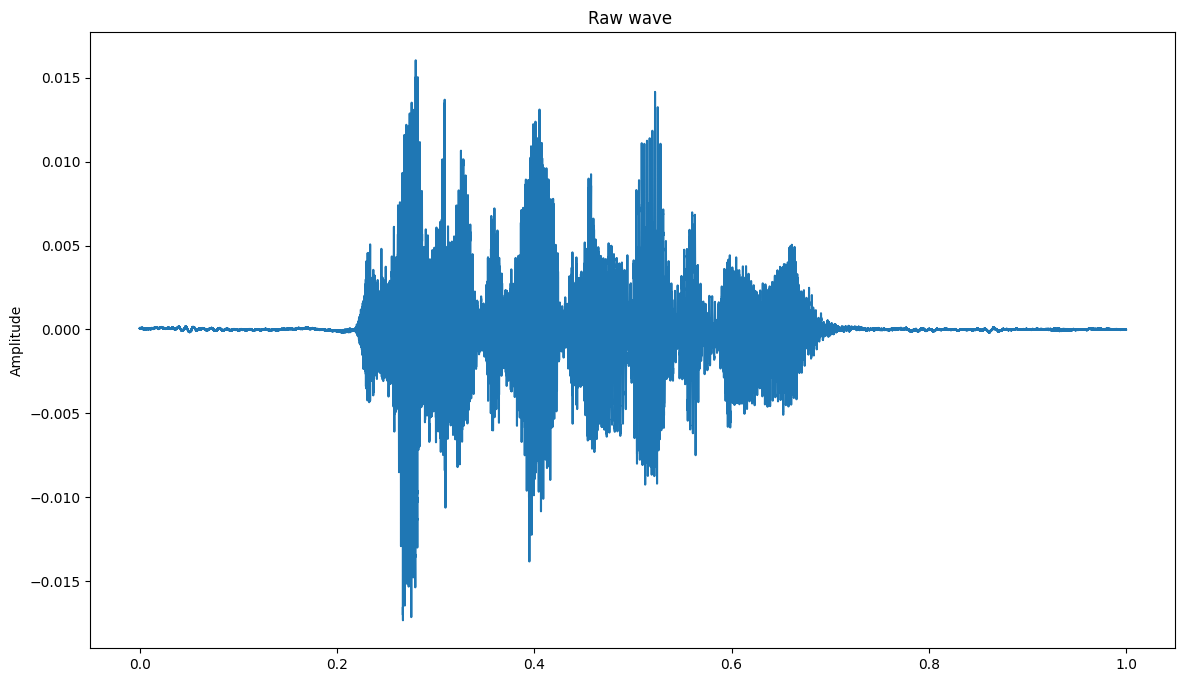

In [38]:
x = librosa.effects.pitch_shift(X, sr =sample_rate, n_steps=1)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [39]:
# Data Making Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 400/400 [00:13<00:00, 29.71it/s]


In [40]:
# Data Making Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = librosa.effects.pitch_shift(X, sr =sample_rate, n_steps=1)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 400/400 [01:01<00:00,  6.56it/s]


In [41]:
len(syn_data1), len(syn_data2)

(400, 400)

In [42]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [43]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

400

In [44]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-59.443994,-56.194230,-55.509866,-56.124698,-53.961199,-55.406158,-55.076346,-54.190702,-55.144779,-57.372356,...,-57.416969,-55.736061,-54.078498,-54.479071,-53.957823,-55.622187,-57.528844,-56.142526,-57.139426,male_calm
1,-67.541255,-66.268645,-64.309824,-65.788303,-65.800928,-66.073387,-64.527555,-64.220392,-66.791142,-66.584888,...,-66.524136,-66.845112,-66.730612,-67.367872,-67.475473,-67.525167,-66.589240,-65.169852,-66.344912,male_calm
2,-53.955679,-52.998753,-52.370620,-52.867154,-53.156445,-54.230310,-53.759718,-53.274839,-53.507517,-52.014093,...,-57.328390,-56.164827,-52.024534,-50.855732,-51.418772,-52.828779,-53.916405,-53.859799,-55.231972,male_calm
3,-69.051839,-68.998575,-69.048582,-68.969464,-69.051839,-68.928091,-69.051839,-69.051839,-68.533181,-67.794565,...,-67.471245,-69.051839,-69.051839,-69.036585,-67.981114,-69.051840,0.000000,0.000000,0.000000,male_calm
4,-73.836125,-73.587984,-71.845767,-71.383570,-73.866601,-73.869838,-73.786335,-72.514909,-71.742172,-73.657770,...,-73.654942,-73.437668,-73.571860,-73.598473,-73.819926,-73.892911,-73.515334,-73.553133,-73.692160,male_calm


In [45]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

400

In [46]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-71.181976,-71.181976,-71.181976,-71.181976,-71.181976,-71.181976,-71.181976,-71.181976,-71.181976,-71.181976,...,-71.181976,-71.181976,-69.693192,-69.525444,-71.181976,-70.702393,-70.080109,-70.901016,-71.181976,male_calm
1,-67.744766,-67.744766,-67.744766,-67.744766,-67.744766,-67.744766,-65.485229,-67.731575,-67.744766,-67.744766,...,-67.744766,-67.744766,-67.744766,-67.744766,-67.744766,-67.744766,-67.744766,-67.722160,-67.744766,male_calm
2,-71.463470,-71.083359,-71.463470,-71.463470,-71.463470,-71.463470,-71.463470,-71.463470,-71.463470,-69.616402,...,-71.463470,-71.463470,-71.463470,-71.463470,-71.463470,-71.463470,-71.463470,-71.463470,-71.463470,male_calm
3,-69.875305,-69.875305,-69.875305,-69.875305,-69.875305,-69.875305,-69.875305,-69.875305,-69.875305,-69.875305,...,-69.875305,-69.875305,-69.875305,-69.875305,-69.875305,-69.875305,0.000000,0.000000,0.000000,male_calm
4,-74.990776,-74.990776,-74.990776,-74.731194,-74.990776,-74.990776,-74.990776,-74.769318,-73.887497,-74.990776,...,-74.990776,-74.990776,-74.990776,-74.990776,-74.990776,-74.990776,-74.990776,-74.990776,-74.990776,male_calm


In [47]:
# Combining the Proccessed data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()


,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082,male_calm
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127472,-67.557671,male_calm
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359,male_calm
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,0.000000,0.000000,0.000000,male_calm
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,male_calm


## Train test split

In [48]:
from sklearn.model_selection import StratifiedShuffleSplit
X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [49]:
y_train.value_counts()

label
male_fearful    192
male_sad        192
male_angry      192
male_calm       192
male_happy      192
Name: count, dtype: int64

In [50]:
y_test.value_counts()

label
male_angry      48
male_fearful    48
male_calm       48
male_sad        48
male_happy      48
Name: count, dtype: int64

In [51]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [52]:
y_train

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [53]:
X_train

array([[-39.69940089, -36.59429726, -36.3669701 , ...,   0.        ,
          0.        ,   0.        ],
       [-43.8127594 , -43.9316597 , -44.57232666, ...,   0.        ,
          0.        ,   0.        ],
       [-56.93128967, -56.58560562, -60.33594513, ..., -58.06570816,
        -64.64757538, -68.69346619],
       ...,
       [-49.59490297, -48.51282688, -49.95956525, ...,   0.        ,
          0.        ,   0.        ],
       [-48.03632382, -46.04582198, -44.72424781, ...,   0.        ,
          0.        ,   0.        ],
       [-46.38318253, -47.40749741, -49.47633743, ..., -59.47906876,
        -60.39190674, -57.27294159]])

In [54]:
X_train.shape

(960, 259)

## Deep Learning CNN Model

In [55]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [56]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [57]:
model = Sequential()

## First layer
model.add(Conv1D(256, 8, padding='valid',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))

## Second layer
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))

## Third layer
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))

## Fourth layer
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))

## Fifth layer
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))

## Sixth layer
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))

## Seventh layer
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))

# Last layer
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(5))
model.add(Activation('softmax'))
#opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False) 

In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 252, 256)          2304      
                                                                 
 activation (Activation)     (None, 252, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 252, 256)          524544    
                                                                 
 batch_normalization (BatchN  (None, 252, 256)         1024      
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 252, 256)          0         
                                                                 
 dropout (Dropout)           (None, 252, 256)          0         
                                                        

In [59]:
# Compile your model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('C:\\Users\\ruizh\\Documents\\Y2S2\\tryhack\\emo_models\\New Folder\\Data_noiseNshift.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=100,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Epoch 1/100


60/60 [==============================] - 13s 78ms/step - loss: 1.4319 - accuracy: 0.3750 - val_loss: 1.9017 - val_accuracy: 0.2042 - lr: 0.0010
Epoch 2/100
60/60 [==============================] - 3s 50ms/step - loss: 1.3233 - accuracy: 0.4458 - val_loss: 1.6955 - val_accuracy: 0.2750 - lr: 0.0010
Epoch 3/100
60/60 [==============================] - 3s 49ms/step - loss: 1.2988 - accuracy: 0.4625 - val_loss: 5.4174 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 4/100
60/60 [==============================] - 3s 50ms/step - loss: 1.2696 - accuracy: 0.4740 - val_loss: 1.4486 - val_accuracy: 0.3708 - lr: 0.0010
Epoch 5/100
60/60 [==============================] - 3s 51ms/step - loss: 1.2353 - accuracy: 0.4771 - val_loss: 1.3959 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 6/100
60/60 [==============================] - 3s 44ms/step - loss: 1.2373 - accuracy: 0.5115 - val_loss: 3.9352 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 7/100
60/60 [==============================] - 3s 49ms/step - loss: 1.1879 

## Result visualisation

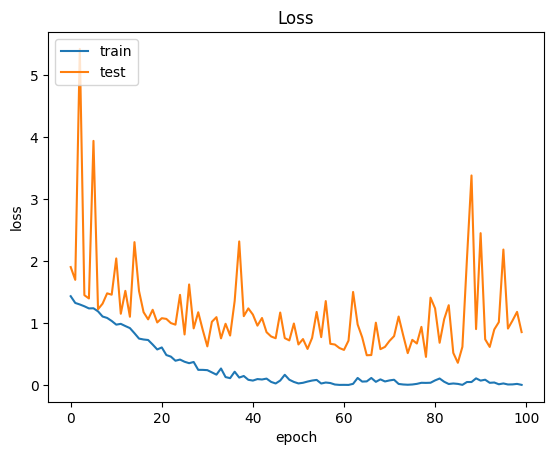

In [91]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Save Model

In [62]:
import json
model_json = model.to_json()
with open("C:\\Users\\ruizh\\Documents\\Y2S2\\tryhack\emo_models\\Saved_Models\\model.json", "w") as json_file:
    json_file.write(model_json)

In [63]:
len(X_test)

240

In [64]:
import tensorflow as tf
from tensorflow.keras.initializers import glorot_uniform
loaded_model = tf.keras.models.load_model("C:\\Users\\ruizh\\Documents\\Y2S2\\tryhack\\emo_models\\New Folder\\Data_noiseNshift.h5",custom_objects={'GlorotUniform': glorot_uniform()})
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 89.58%


## Test on test data

In [65]:
len(data2_df)

400

In [66]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data2_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████| 400/400 [00:10<00:00, 36.53it/s]


In [67]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

25/25 [==============================] - 0s 12ms/step


In [68]:
preds

array([[9.0434116e-07, 9.9998033e-01, 3.8336168e-07, 1.3998091e-07,
        1.8219698e-05],
       [3.7333277e-05, 9.9838150e-01, 3.8278413e-05, 1.6068832e-04,
        1.3820885e-03],
       [1.1714535e-07, 9.9997962e-01, 1.3002538e-07, 3.0604835e-07,
        1.9842890e-05],
       ...,
       [1.2881599e-08, 7.4575901e-09, 9.9999905e-01, 7.9024022e-07,
        9.2174012e-08],
       [5.9375985e-08, 7.1795108e-09, 9.9999440e-01, 1.2152055e-06,
        4.3124992e-06],
       [4.5006759e-06, 1.0029185e-07, 9.9998951e-01, 2.6432724e-06,
        3.1930663e-06]], dtype=float32)

In [69]:
preds1=preds.argmax(axis=1)

In [70]:
preds1

array([1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 4, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 4, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 3, 0, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,

In [71]:
abc = preds1.astype(int).flatten()

In [72]:
print(abc)

[1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 2 2 4 2 2
 2 2 2 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 2 2
 4 2 2 2 2 2 1 1 1 1 1 1 1 1 3 3 0 3 3 3 3 3 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0
 0 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 0 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 1 4 4 4 4 4 4 4 0
 0 0 0 0 0 0 0 2 4 2 2 2 2 2 2 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 4 4 4 4 4 4
 4 4 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 4 4 4
 4 4 4 4 4 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3
 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 3 3
 3 3 3 3 3 3 1 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 2 3 2 2 2 2 2 2]


In [73]:
predictions = (lb.inverse_transform((abc)))

In [74]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_calm
1,male_calm
2,male_calm
3,male_calm
4,male_calm
5,male_calm
6,male_calm
7,male_calm
8,male_happy
9,male_happy


In [75]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [76]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_calm
1,male_calm
2,male_calm
3,male_calm
4,male_calm
5,male_calm
6,male_calm
7,male_calm
8,male_happy
9,male_happy


In [77]:
finaldf = actualdf.join(preddf)
#abc1234 = finaldf.astype(float).flatten()
#finalvalues = (lb.inverse_transform((abc1234)))

## Actual vs Predicted Values Comparison

In [78]:
finaldf[40:60]

,actualvalues,predictedvalues
40,male_calm,male_calm
41,male_calm,male_calm
42,male_calm,male_calm
43,male_calm,male_calm
44,male_calm,male_calm
45,male_calm,male_calm
46,male_calm,male_calm
47,male_calm,male_calm
48,male_happy,male_happy
49,male_happy,male_happy


In [79]:
finaldf.groupby('actualvalues').count()


,predictedvalues
actualvalues,
male_angry,80
male_calm,80
male_fearful,80
male_happy,80
male_sad,80


In [80]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
male_angry,81
male_calm,82
male_fearful,76
male_happy,80
male_sad,81


In [81]:
finaldf.to_csv('C:\\Users\\ruizh\\Downloads\\sentiment-predictor-for-stress-detection-main\\New Folder\\Predictions.csv', index=False)

## Visualise with confusion matrix

In [82]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [83]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

98.25

In [84]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

98.24492429202574

In [85]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[80,  0,  0,  0,  0],
       [ 0, 80,  0,  0,  0],
       [ 0,  0, 76,  1,  3],
       [ 1,  0,  0, 79,  0],
       [ 0,  2,  0,  0, 78]], dtype=int64)

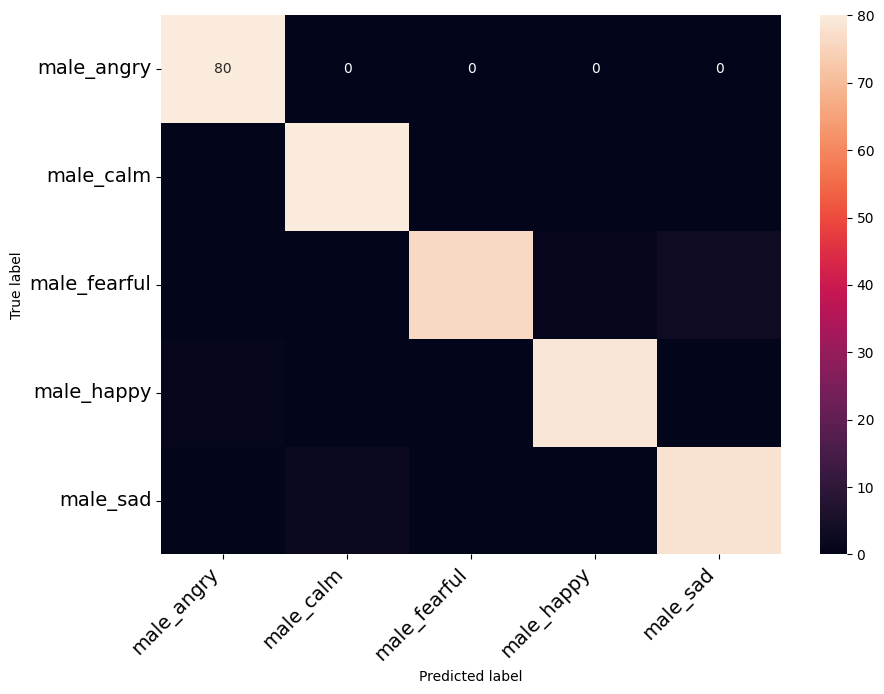

In [86]:
# Visualize Confusion Matrix 

class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
#class_names1 = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
#class_names = ['male_negative', 'male_neutral', 'male_positive']
#class_names = ['male_negative', 'male_positive']
#class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)